In [7]:
import requests
import string
from pprint import pprint
import re
import os
import tempfile
from bs4 import BeautifulSoup
from collections import Counter, OrderedDict
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'size'   : 14}
matplotlib.rc('font', **font)
hookRegex = re.compile(r'\[.*\]')
tireRegex = re.compile(r' -')
engnameRegex = re.compile(r'_\(\w+\)')
chars_to_remove = string.punctuation.replace('-', '') + '—„“»«'
api_url = 'http://api.genius.com'
base_url = 'http://genius.com'
headers = {'Authorization': 'Bearer ' + open('./.bearer_token.txt', 'r').read().rstrip('\n')}

In [8]:
def remove_unnecessary(textfile):
    return tireRegex.sub('', hookRegex.sub('',textfile).translate(str.maketrans('','',chars_to_remove)))

class Artist(object):
    artist_id = ''
    songlist = []
    artist_name = ''
    def __init__(self, name, artist_id=False, write_id=False):
        self.name = name
        if artist_id:
            self.artist_id = artist_id
        else:
#             print("Finding the ID of an artist " + self.name)
            search_url = api_url + '/search'
            data = {'q': self.name}
            response = requests.get(search_url, params=data, headers=headers)
            self.artist_id = response.json()['response']['hits'][0]['result']['primary_artist']['api_path']
#         print("ID of an artist " + self.name + " is " + self.artist_id[9:])
        self.artist_name = response.json()['response']['hits'][0]['result']['primary_artist']['name']
        
        if write_id:
            with open('./artists_id_list.txt', 'r+') as textfile:
                if self.artist_id in textfile.read():
                    pass
                else:
                    textfile.write(textfile.read() + '\n' + self.artist_name + "  -  " + self.artist_id)
                    
        list_of_songs = []
#         print("Getting the list of songs")
        for page in range(1,4):
            res = requests.get(api_url + self.artist_id + '/songs?sort=popularity&per_page=50&page=' + str(page), headers=headers)
#             print("Going through page " + str(page))
            for song in res.json()['response']['songs']:
                if ("Ft." in song['full_title']) | ("Remix" in song['full_title']):
                    pass
#                     print(song['full_title'] + " is a feat, skipping")
                else:
                    song_url = song['url']
                    list_of_songs.append(song_url)
        self.songlist = list_of_songs
    
    def perform_task(self):
        with open("./lyrics/" + self.artist_name.replace(' ', '_') + '_lyrics.txt', 'w') as lyricsfile:
            for song in self.songlist:
#                 print(str(self.songlist.index(song)) + " Now scraping " + song[19:])
                page_url = song
                res = requests.get(page_url, headers=headers)
                res.text
                page = requests.get(page_url)
                html = BeautifulSoup(page.text, 'html.parser')
                lyrics = html.find(class_='lyrics').get_text()
                lyricsfile.write(remove_unnecessary(lyrics.lower()))
        return



In [16]:
def get_percentage(words, total):
    return round(words*100/total, 2)

def ord_dict(input_dict):
    return OrderedDict(sorted(input_dict.items(), key = itemgetter(1), reverse = True))

class Lyric_file(object): 
    the_text = ''
    the_list = []
    the_counter = {}
    the_total_words = 0
    the_total_diff_words = 0
    artist_name = ''
    def __init__(self, location):
        self.location = location
        self.the_text = open(self.location, 'r').read()
        self.the_list = self.the_text.split()
        self.the_counter = Counter(self.the_list)
        self.the_total_words = len(self.the_list)
        self.the_total_diff_words = len(self.the_counter)
        self.artist_name = engnameRegex.sub('', location[13:-11]).replace('_', ' ')
        
    def get_most_common(self, number):
        return self.the_counter.most_common(number)
    
    def get_most_common_percentage(self, number):
        result_list = []
        for word in self.get_most_common(number):
            result_list.append((word[0], get_percentage(word[1], self.the_total_words)))
        return result_list
    
    def get_percentage_of_word(self, word):
        return get_percentage(self.the_counter[word],self.the_total_words)
    
    def get_vocab_size(self):
        return len(self.the_list)/self.the_total_diff_words
    

In [17]:
def get_first_ten_k(oldlocation, newlocation):
    oldfile = open(oldlocation, 'r')
    newfile = open(newlocation, 'w')
    l = oldfile.read().split()
    if len(l) > 10000:
        for word in l[:10000]:
            newfile.write(word.replace("ё", "е") + "\n")
        oldfile.close()
        newfile.close()
    else:
        print(oldlocation[:-4] + " has not enough lyrics")
        os.remove(newlocation)
    return

def get_unique_words(total_words, artist_count):
    shared_items = set(total_words.items()) & set(artist_count.items())
    return shared_items

def get_total_file(directory, location):
    with open(location, 'w') as total_file:
        for lyrics in os.listdir(directory):
            total_file.write(open(directory+lyrics, 'r').read())
    return

In [16]:
### USING THE STUFF CREATED ABOVE, SCRAPE ALL NON-FEAT LYRICS FOR TH ARTISTS IN artists_source.txt

with open('./artists_source.txt', 'r') as id_list:
    artistlist = id_list.readlines()
    for artist in artistlist:
        the_artist = Artist(artist.rstrip("\n"), write_id=True)
        print("Now scraping " + the_artist.artist_name + ", " + str(len(artistlist) - 1 - artistlist.index(artist)) + " remaining")
        the_artist.perform_task()

Now scraping Oxxxymiron, 35 remaining
Now scraping макулатура (makulatura), 34 remaining
Now scraping Каспийский Груз (KG), 33 remaining
Now scraping Гуф (Guf), 32 remaining
Now scraping SidxRam, 31 remaining
Now scraping Слава КПСС (Slava KPSS), 30 remaining
Now scraping ЛСП (LSP), 29 remaining
Now scraping Скриптонит (Scriptonite), 28 remaining
Now scraping Каста (Kasta), 27 remaining
Now scraping Кровосток (Krovostok), 26 remaining
Now scraping Элджей (Eldzhey), 25 remaining
Now scraping ATL, 24 remaining
Now scraping Ноггано (Noggano), 23 remaining
Now scraping Big Russian Boss, 22 remaining
Now scraping Bumble Beezy, 21 remaining
Now scraping Птаха (Ptaha), 20 remaining
Now scraping Pharaoh, 19 remaining
Now scraping Макс Корж (Max Korzh), 18 remaining
Now scraping Тимати (Timati), 17 remaining
Now scraping T-Fest, 16 remaining
Now scraping Rickey F, 15 remaining
Now scraping СД (SD aka Sadist), 14 remaining
Now scraping Хаски (Husky), 13 remaining
Now scraping Face, 12 remaining


In [34]:
for file in os.listdir('./lyrics/'):
    get_first_ten_k('./lyrics/' + file, './cut_lyrics/' + file)

get_total_file('./cut_lyrics/', './total_cut.txt')
get_total_file('./lyrics/', './total.txt')

./lyrics/L’One_lyrics has not enough lyrics
./lyrics/Элджей_(Eldzhey)_lyrics has not enough lyrics
./lyrics/Каспийский_Груз_(KG)_lyrics has not enough lyrics
./lyrics/T-Fest_lyrics has not enough lyrics
./lyrics/Ноггано_(Noggano)_lyrics has not enough lyrics
./lyrics/Макс_Корж_(Max_Korzh)_lyrics has not enough lyrics
./lyrics/Птаха_(Ptaha)_lyrics has not enough lyrics
./lyrics/Паша_Техник_(Pasha_Technique)_lyrics has not enough lyrics
./lyrics/Карандаш_(Karandash)_lyrics has not enough lyrics
./lyrics/Мот_(Mmott)_lyrics has not enough lyrics
./lyrics/Тимати_(Timati)_lyrics has not enough lyrics


In [18]:
class File_dir(object):
    file_list = []
    total_lyric = None
    total_counter = None
    def __init__(self, location, total_file):
        self.location = location
        self.total_file = total_file
        
        self.total_lyric = Lyric_file(total_file)
        self.total_counter = self.total_lyric.the_counter
        
        
        res_list = []
        for file in os.listdir(location):
            if "direct" in file:
                continue
            res_list.append(location + file)
        self.file_list = res_list
        return
    
    def get_uniq_words(self):
        res_dict = {}
        for artist in self.file_list:
            obj = Lyric_file(artist)
            res_dict[obj.artist_name] = len(get_unique_words(self.total_counter, obj.the_counter))
        return ord_dict(res_dict)
    
    def get_wordgroup_percentage(self, wordlist):
        res_dict = {}
        for artist in self.file_list:
            obj = Lyric_file(artist)
            total_self_percentage = 0
            for word in wordlist:
                total_self_percentage += obj.get_percentage_of_word(word)
            res_dict[obj.artist_name] = round(total_self_percentage, 2)
        return ord_dict(res_dict)
cut_dir = File_dir('./cut_lyrics/', './total_cut.txt')

In [ ]:
def plot_graph(input_dict, savedname, y_label=False, graph_label=False):
    fig = plt.figure(figsize=(20, 20), dpi=100)
    ax = fig.add_subplot(111)
    ind = np.arange(len(input_dict))                # the x locations for the groups
    width = 0.70                      # the width of the bars

    rects1 = ax.bar(ind, input_dict.values(), width,
                    color='#BBBBBB')
    
    for rect, label in zip(rects1, input_dict.values()):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height, str(label), ha='center', va='bottom') 
    if y_label:
        ax.set_ylabel(y_label)
    if graph_label:
        fig.suptitle(graph_label)
    ax.set_xticks(ind)
    xtickNames = ax.set_xticklabels(input_dict.keys(), rotation='vertical')
    plt.savefig(savedname, bbox_inches='tight')
    plt.show()


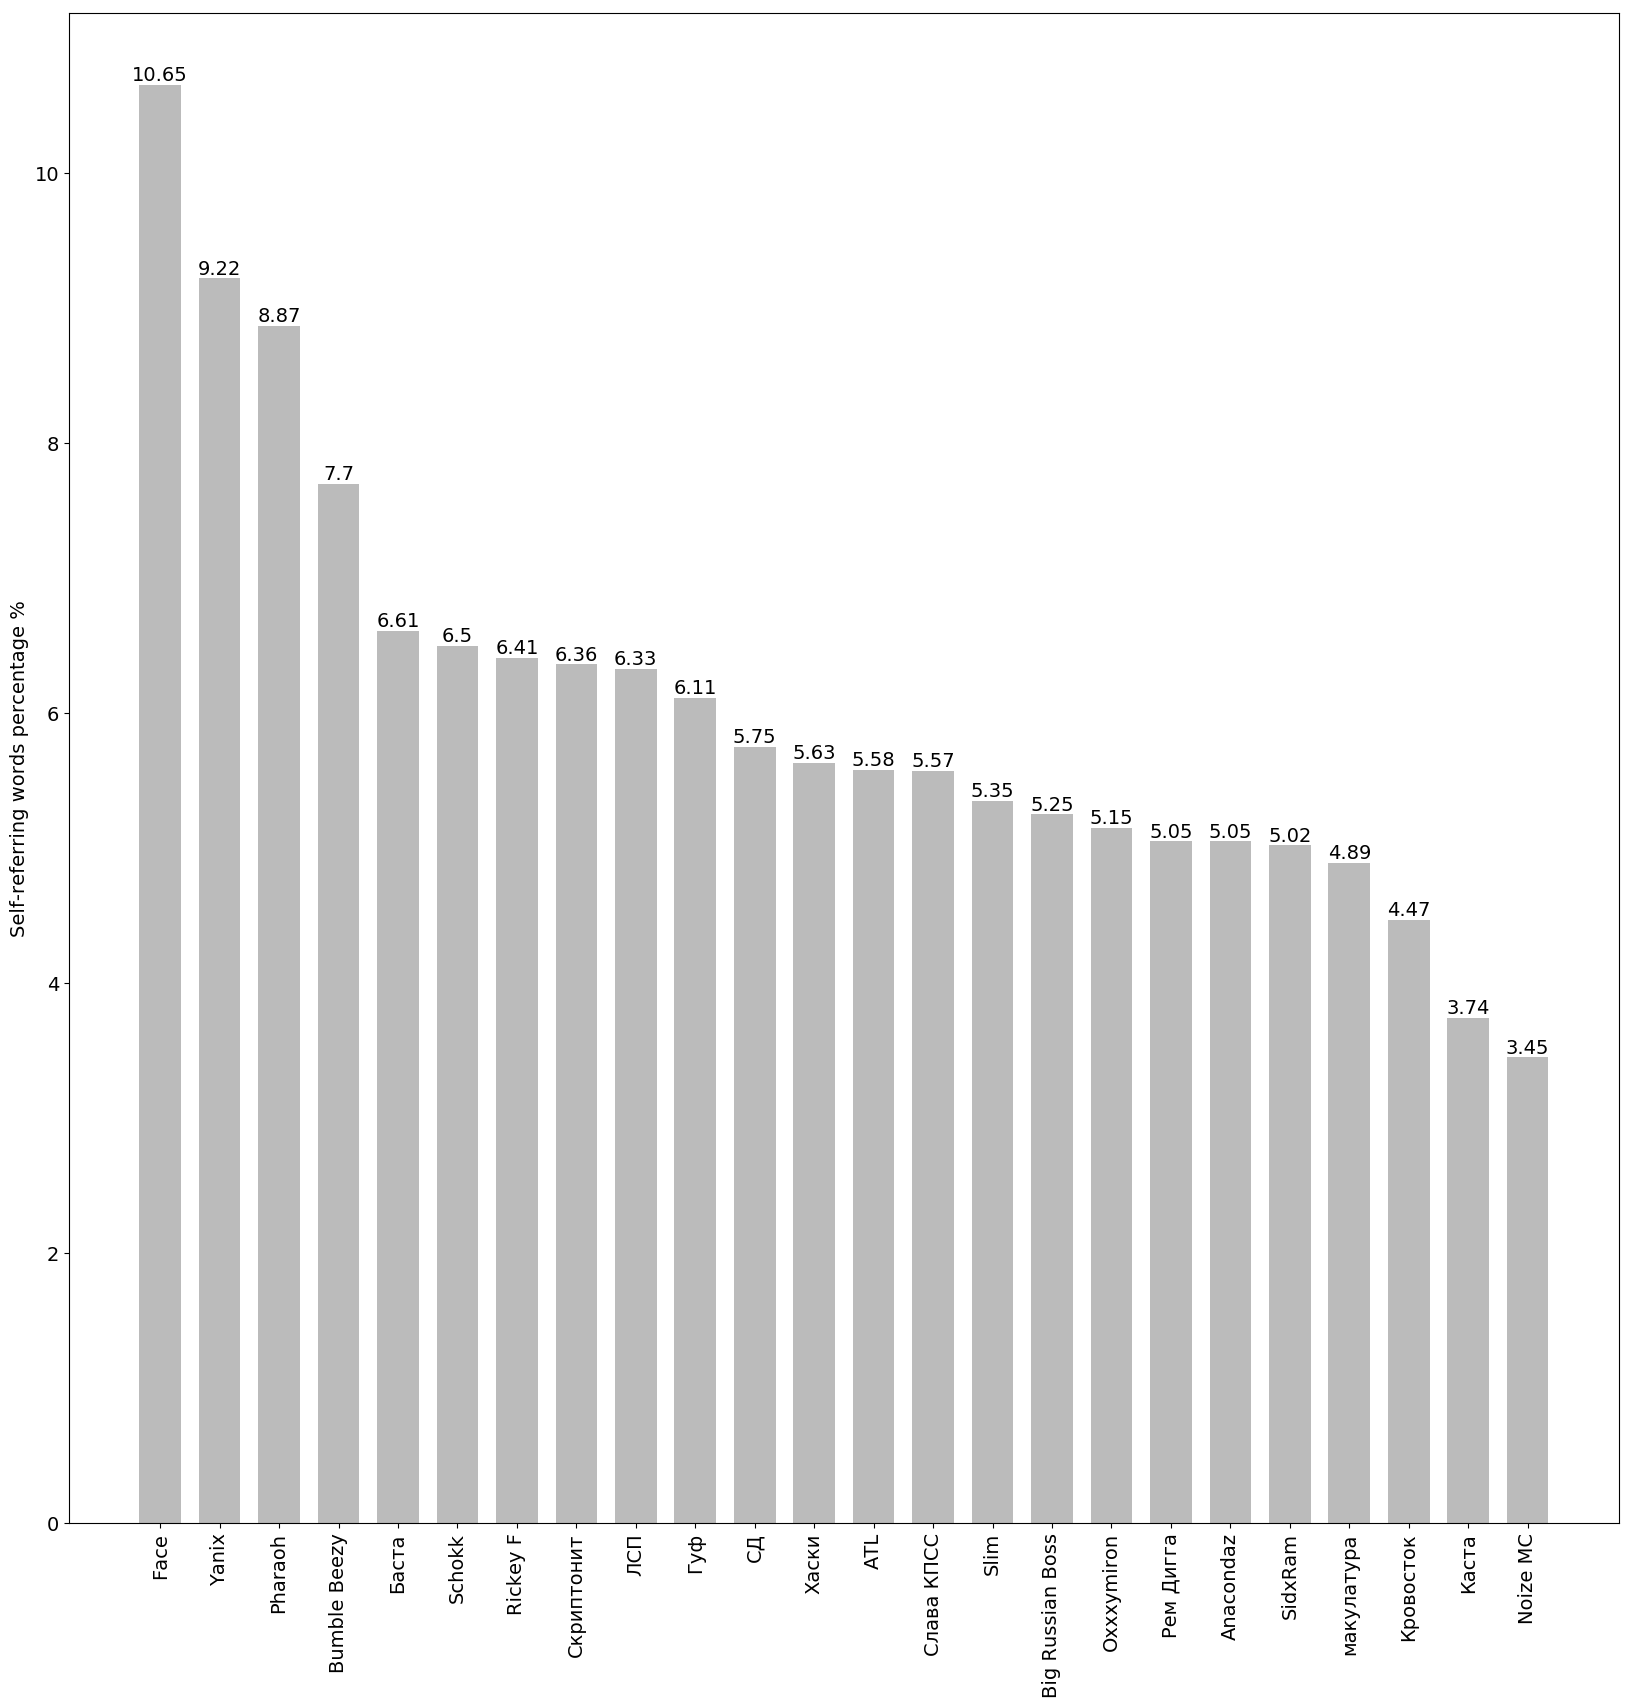

In [19]:
self_referring_words = ["я", "мой", "мы", "мне", "меня", "мои", "нас", "мое", "наше", "моя"]
plot_graph(cut_dir.get_wordgroup_percentage(self_referring_words),
           './figs/self_love.png', 
           y_label="Self-referring words percentage %")

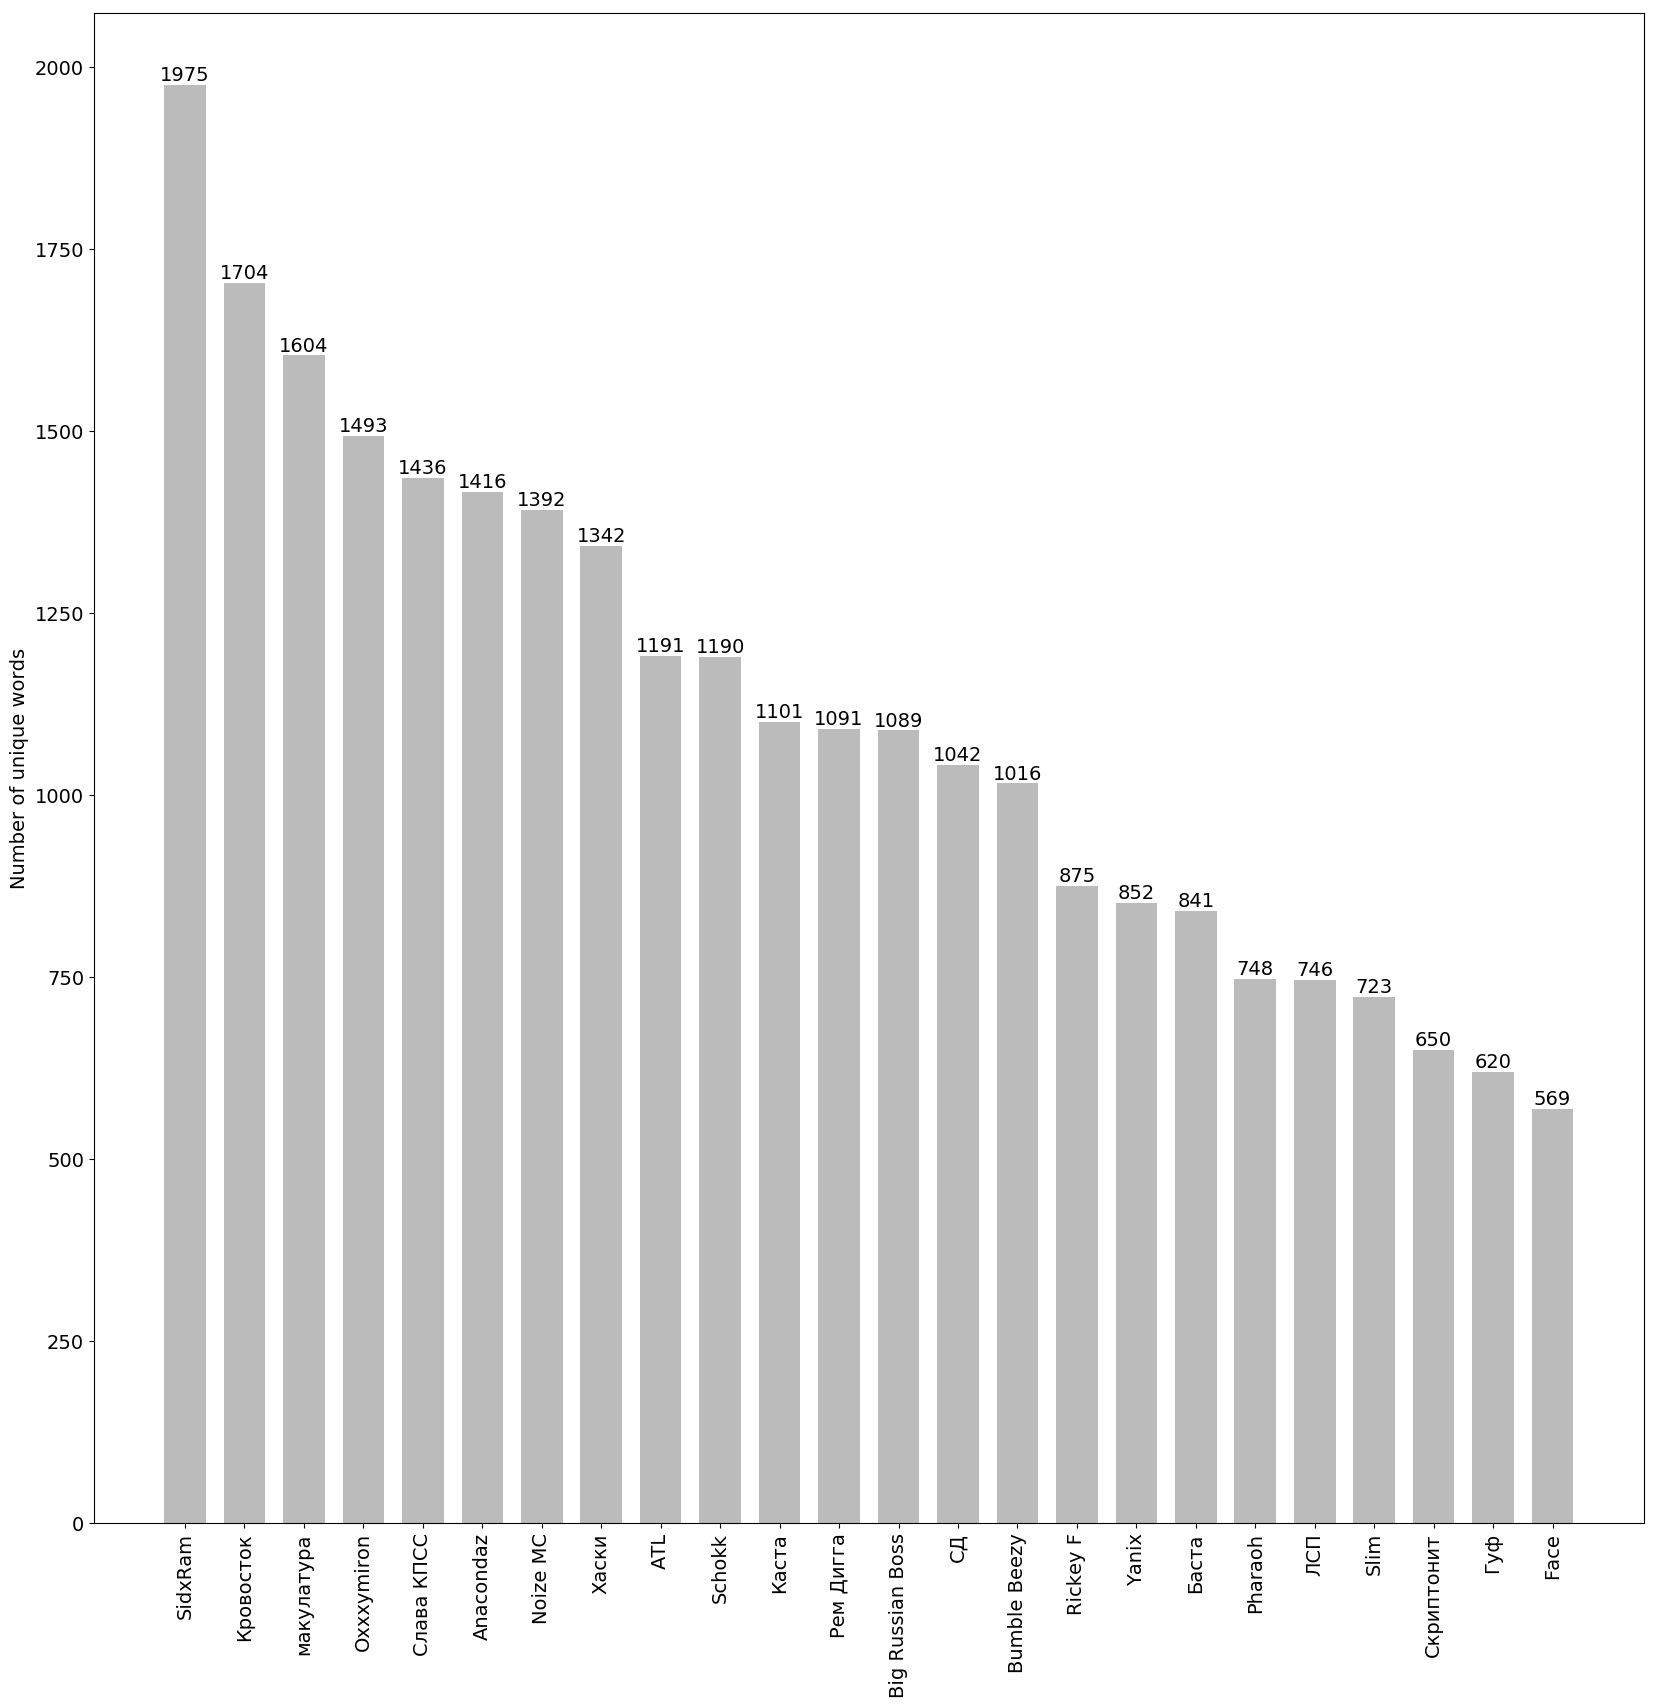

In [20]:
plot_graph(cut_dir.get_uniq_words(), 
           './figs/unique_words.png',
          y_label="Number of unique words")

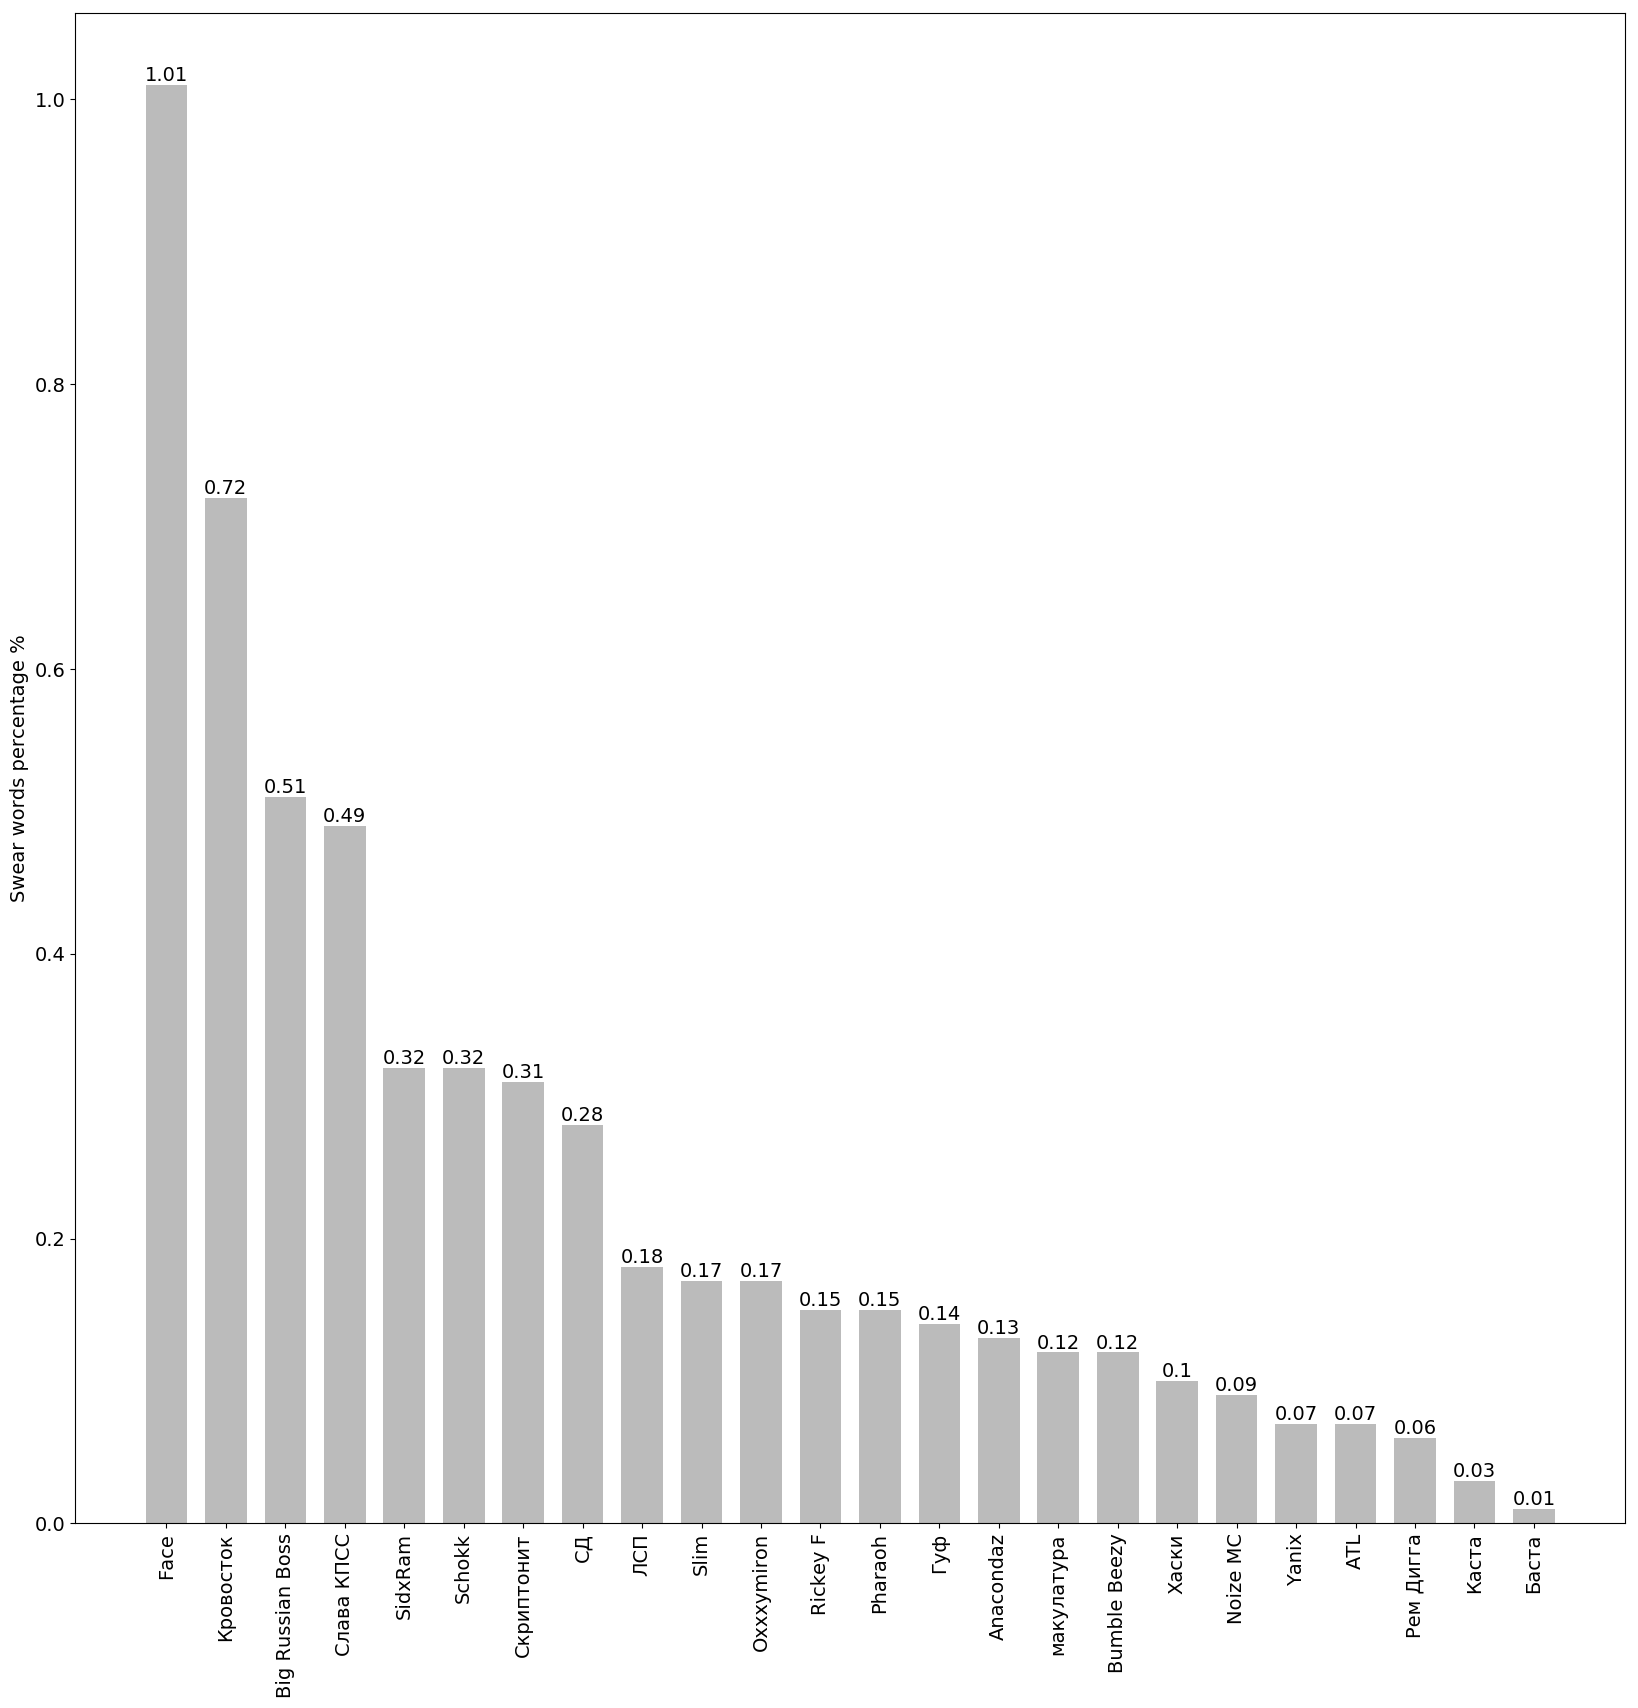

In [21]:
swear_words = ["блядь", "хуй", "ебать", "пиздец", "пизда", "ебал", "пидор", "говно", "хуево"]
plot_graph(cut_dir.get_wordgroup_percentage(swear_words),
           './figs/swear_words.png', 
           y_label="Swear words percentage %")